<a href="https://colab.research.google.com/github/Ash100/CADD_Project/blob/main/Pharmacophore_Modeling_Part_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pharmacophore - Protein data acquisition: Protein Data Bank (PDB)

My name is **Dr. Ashfaq Ahmad**, and this tutorial is inspired from the TeachOpenCADD project of Volkamer Lab. Students and Researchers with a basic Biology background found it difficult to run these analysis directly. Therefore, with some modification in codes, this notebook allows everyone to directly use it for analysis. Also this notebook is primarily cloned for teaching and research purposes. For a detail video tutorial, Bioinformatics Insights https://www.youtube.com/channel/UC2Z_WaqTjbvXGGQNpIF9nAg

Authors:

- Anja Georgi, CADD seminar, 2017, Charité/FU Berlin
- Majid Vafadar, CADD seminar, 2018, Charité/FU Berlin
- Jaime Rodríguez-Guerra, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, [Volkamer lab, Charité](https://volkamerlab.org/)

For further reading, please read the specified manuscript: ([_J. Cheminform._ (2019), **11**, 1-7](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x)), comprising of talktorials T001-T010.

## Aim of this talktorial

This tutorial will access PDB to collect data. The files generated here will be used in next part to generate a ligand-based ensemble pharmacophore for EGFR. Therefore, we will
(i) fetch all PDB IDs for EGFR from the PDB database that fullfil certain criteria (e.g. ligand-bound structures with high resolution),
(ii) retrieve protein-ligand structures with the best structural quality,
(iii) align all structures, and
(iv) extract and save the ligands to be used in the next talktorial.

### References

* Protein Data Bank
([PDB website](http://www.rcsb.org/))
* `pypdb` Python package
([_Bioinformatics_ (2016), **1**, 159-60](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btv543); [documentation](http://www.wgilpin.com/pypdb_docs/html/))
* `biotite` Python package ([_BMC Bioinformatics_ (2018), **19**](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2367-z); [documentation](https://www.biotite-python.org/))
* Molecular superposition with the Python package `opencadd` ([repository](https://github.com/volkamerlab/opencadd))

## Theory

### Protein Data Bank (PDB)

The RCSB Protein Data Bank (PDB) is a comprehensive structural biology information database and a key resource in areas of structural biology, such as structural genomics and drug design ([PDB website](http://www.rcsb.org/)).

Structural data is generated from structural determination methods such as X-ray crystallography (most common method), nuclear magnetic resonance (NMR), and cryo electron microscopy (cryo-EM).


### Query the PDB using the Python packages `biotite` and `pypdb`

Each structure in the PDB database is linked to many different fields to hold meta information. Check out the complete list of available fields for [chemicals](https://search.rcsb.org/chemical-search-attributes.html)/[structures](https://search.rcsb.org/structure-search-attributes.html) and supported operators on the RCSB website. The Python package `biotite` provides the convenient module `databases.rcsb` (see [docs](https://www.biotite-python.org/apidoc/biotite.database.rcsb.html)), which allows us to query one (`FieldQuery`, see [docs](https://www.biotite-python.org/apidoc/biotite.database.rcsb.FieldQuery.html#biotite.database.rcsb.FieldQuery)) or more (`CompositeQuery`, see [docs](https://www.biotite-python.org/apidoc/biotite.database.rcsb.CompositeQuery.html#biotite.database.rcsb.CompositeQuery)) of these fields to retrieve a count (`count`) or list (`search`) of PDB IDs that match our criteria.

The Python package `pypdb` offers an interface for the PDB to not only query for PDB IDs but also to download associated metadata and structural files ([_Bioinformatics_ (2016), **1**, 159-60](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btv543), [documentation](http://www.wgilpin.com/pypdb_docs/html/)). Check out the [demo](https://github.com/williamgilpin/pypdb/blob/master/demos/demos.ipynb) notebook introducing the `pypdb` API.

We will use both packages in this notebook: `biotite` to quickly filter down the many structures in the PDB given certain criteria and `pypdb` to download metadata and structural files for specific PDB entries of interest.

## Let's Begin

In [ ]:
#Install Conda - Kernal Restart will take place
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
# Install mamba
!conda install -c conda-forge mamba -y

# Use mamba to install packages
!mamba install -c conda-forge -c defaults python=3.8 -y
!mamba install -c conda-forge -c defaults biopython=1.77 -y
!mamba install -c conda-forge -c defaults pip -y
!mamba install -c conda-forge -c defaults jupyterlab=3 -y
!mamba install -c conda-forge -c defaults jupyter_client=7.4.9 -y
!mamba install -c conda-forge -c defaults scikit-learn -y
!mamba install -c conda-forge -c defaults seaborn -y
!mamba install -c conda-forge -c defaults matplotlib-venn -y
!mamba install -c conda-forge -c defaults rdkit -y
!mamba install -c conda-forge -c defaults pypdb -y
!mamba install -c conda-forge -c defaults biotite -y
!mamba install -c conda-forge -c defaults 'mdanalysis>=1.0.0' -y
!mamba install -c conda-forge -c defaults beautifulsoup4 requests tqdm redo requests-cache -y

In [ ]:
!pip install git+https://github.com/volkamerlab/opencadd.git

In [ ]:
from opencadd.structure.superposition.api import align, METHODS
from opencadd.structure.core import Structure

In [ ]:
import collections
import logging
import pathlib
import time
import warnings
import datetime

import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from tqdm.auto import tqdm
import redo
import requests_cache
import pypdb
import biotite.database.rcsb as rcsb
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

from opencadd.structure.superposition.api import align, METHODS
from opencadd.structure.core import Structure

# Disable some unneeded warnings
logger = logging.getLogger("opencadd")
logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

# Cache requests -- this will speed up repeated queries to PDB
requests_cache.install_cache("rcsb_pdb", backend="memory")

In [ ]:
!pip install nglview==3.0.8
!pip install "ipywidgets>=7,<8"

In [ ]:
!jupyter-nbextension enable nglview --py --sys-prefix

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import os
import sys
from urllib.request import urlretrieve
import Bio
from Bio import PDB
from Bio import SeqIO, SearchIO, Entrez
from Bio.Seq import Seq
import pylab
import urllib
import nglview as nv
from collections import Counter
from Bio.PDB import PDBParser,MMCIFParser

Now we are going to define our path, which will be 'content' directory of this notebook.

In [ ]:
# Define paths
HERE = pathlib.Path(_dh[-1])
DATA = pathlib.Path('/content/')

### Select a query protein

We use EGFR as query protein for this talktorial. The UniProt ID of EGFR is `P00533`, which will be used in the following to query the PDB database.

In [ ]:
uniprot_id = "P00533"

### Get the number of PDB entries for a query protein

How many structures are available in the PDB for EGFR (at the time this notebook was last run)?

In [ ]:
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
today = datetime.datetime.now()
print(
    f"Number of structures on {today.year}-{today.month}-{today.day}: {rcsb.count(query_by_uniprot_id)}"
)

#General PDB statistics
How many structures were available in every year since the [PDB was established in 1971](https://www.rcsb.org/pages/about-us/history)?

In [ ]:
# Define lists for years and number of structures available in a given year
years = range(1971, datetime.datetime.now().year)
n_structures = []

for year in years:
    # Set latest date for allowed deposition
    before_deposition_date = f"{year}-12-31T23:59:59Z"
    # Set up query for structures deposited latest at given date
    query_by_deposition_date = rcsb.FieldQuery(
        "rcsb_accession_info.deposit_date", less_or_equal=before_deposition_date
    )
    # Set up combined query
    query = rcsb.CompositeQuery(
        [query_by_uniprot_id, query_by_deposition_date],
        "and",
    )
    # Count matching structures and add to list
    n_structures.append(rcsb.count(query))
    # wait shortly to not overload the API
    time.sleep(0.1)

Plot the results!

In [ ]:
plt.plot(years, n_structures)
plt.title("PDB entries for EGFR")
plt.xlabel("Year")
plt.ylabel("Number of structures available in a given year");

### Find PDB entries fullfilling certain conditions

We will search for PDB IDs describing structures in the PDB that fulfill the following criteria:

- **Structures for UniProt ID P00533**: This is our target of interest, EGFR!

- **Structure resolved by X-ray crystallography**: We could include all methods but let's check out the API on how we can select experimental methods.
- **Structure has a resolution less than or equal to 3.0**: The lower the resolution value, the higher is the quality of the structure, i.e. the certainty that the assigned 3D coordinates of the atoms are correct. Atomic orientations can be determined below 3 Å. Thus, this threshold is often used for structures relevant for structure-based drug design.
- **Structure has only one chain**: We do this to make our lives easier lateron.
- **Structure has a ligand with molecular weight greater than 100.0 Da**: PDB-annotated ligands can be ligands, but also solvents and ions. In order to filter only ligand-bound structures, we keep only structures with annotated ligand of a at least 100.0 Da (many solvents and ions weight less). Note: this is a simple, but not comprehensive exclusion of solvents and ions.

We define our criteria (Read above).

In [ ]:
uniprot_id = "P00533"
experimental_method = "X-RAY DIFFRACTION"
max_resolution = 3.0
n_chains = 1
min_ligand_molecular_weight = 100.0

We set up each query.

In [ ]:
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
query_by_experimental_method = rcsb.FieldQuery("exptl.method", exact_match=experimental_method)
query_by_resolution = rcsb.FieldQuery(
    "rcsb_entry_info.resolution_combined", less_or_equal=max_resolution
)
query_by_polymer_count = rcsb.FieldQuery(
    "rcsb_entry_info.deposited_polymer_entity_instance_count", equals=n_chains
)
query_by_ligand_mw = rcsb.FieldQuery(
    "chem_comp.formula_weight", molecular_definition=True, greater=min_ligand_molecular_weight
)

We perform each of the queries alone and check the number of matches per condition.

In [ ]:
print(f"Number of structures with UniProt ID {uniprot_id}: {rcsb.count(query_by_uniprot_id)}")
time.sleep(0.1)  # wait shortly to not overload the API
print(
    f"Number of structures resolved by {experimental_method}: {rcsb.count(query_by_experimental_method)}"
)
time.sleep(0.1)
print(
    f"Number of structures with resolution less than or equal to {max_resolution}: {rcsb.count(query_by_resolution)}"
)
time.sleep(0.1)
print(f"Number of structures with only {n_chains} chain: {rcsb.count(query_by_polymer_count)}")
time.sleep(0.1)
print(
    f"Number of structures with ligand of more than or equal to {min_ligand_molecular_weight} Da: {rcsb.count(query_by_ligand_mw)}"
)

We combine all queries with the `and` operator to match only PDB IDs that fulfill all the conditions.

In [ ]:
query = rcsb.CompositeQuery(
    [
        query_by_uniprot_id,
        query_by_experimental_method,
        query_by_resolution,
        query_by_polymer_count,
        query_by_ligand_mw,
    ],
    "and",
)
pdb_ids = rcsb.search(query)
print(f"Number of matches: {len(pdb_ids)}")
print("Selected PDB IDs:")
print(*pdb_ids)

### Select PDB entries with the hightest resolution

So far we have used certain search criteria to find PDB entries of interest.

At the moment, we cannot access the structures' resolution directly via `biotite`; with `biotite` we can only check if the resolution fullfils a certain condition. Instead we download the full metadata for our selected PDB IDs. To this end, we use from the `pypdb` package the method `describe_pdb`. Each structure's metadata is returned as a dictionary.

Note: we only fetch meta information on PDB structures here, we do not fetch the structures (3D coordinates), yet.

> The `redo.retriable` line is a _decorator_. This wraps the function and provides extra functionality. In this case, it will retry failed queries automatically (10 times maximum).

In [ ]:
@redo.retriable(attempts=10, sleeptime=2)
def describe_one_pdb_id(pdb_id):
    """Fetch meta information from PDB."""
    described = pypdb.describe_pdb(pdb_id)
    if described is None:
        print(f"! Error while fetching {pdb_id}, retrying ...")
        raise ValueError(f"Could not fetch PDB id {pdb_id}")
    return described

In [ ]:
pdbs_data = [describe_one_pdb_id(pdb_id) for pdb_id in tqdm(pdb_ids)]

Let's take a look at the metadata of the first PDB IDs (keys only because the dictionary contains a lot of information, which we do not want to print here). Find more more information about the PDB metadata in the [Beginner's Guide to PDB Structures and the PDBx/mmCIF Format](https://pdb101.rcsb.org/learn/guide-to-understanding-pdb-data/beginner%E2%80%99s-guide-to-pdb-structures-and-the-pdbx-mmcif-format).

In [ ]:
print("\n".join(pdbs_data[0].keys()))

Let's take a closer look at two keys that will be of interest to us: The `"entry"` key which contains the PDB ID (`"id"`) and the `"rcsb_entry_info"` key which contains amongst others the structure's resolution (`"resolution_combined"`).

In [ ]:
pdbs_data[0]["entry"]

In [ ]:
pdbs_data[0]["rcsb_entry_info"]

Now we save the resolution per PDB ID as `pandas` DataFrame, sorted by the resolution in ascending order.

In [ ]:
resolution = pd.DataFrame(
    [
        [pdb_data["entry"]["id"], pdb_data["rcsb_entry_info"]["resolution_combined"][0]]
        for pdb_data in pdbs_data
    ],
    columns=["pdb_id", "resolution"],
).sort_values(by="resolution", ignore_index=True)
resolution

In [ ]:
resolution.to_csv('resolution_data.csv', index=False)

### Get metadata of ligands from top structures

In [ ]:
top_num = 6  # Number of top structures

In the next talktorial, we will build ligand-based ensemble pharmacophores from the top `top_num` structures with the highest resolution.

In [ ]:
selected_pdb_ids = resolution[:top_num]["pdb_id"].to_list()
print(f"Selected PDB IDs: {selected_pdb_ids}")

The selected highest resolution PDB entries can contain ligands targeting different binding sites, e.g. allosteric and orthosteric ligands, which would hamper ligand-based pharmacophore generation. Thus, we will focus on the following 4 structures, which contain ligands in the orthosteric binding pocket. The code provided later in the notebook can be used to verify this.

In [ ]:
selected_pdb_ids = ["5UG9", "5HG8", "5UG8", "5UGC"]
print(f"Selected PDB IDs (frozen set): {selected_pdb_ids}")

We fetch the PDB information about the top `top_num` ligands using `get_ligands`, to be stored as *csv* file (as dictionary per ligand).

If a structure contains several ligands, we select the largest ligand. Note: this is a simple, but not comprehensive method to select a ligand in the binding site of a protein. This approach may also select a cofactor bound to the protein. Therefore, please check the automatically selected top ligands visually before further usage.

In [ ]:
def get_ligands(pdb_id):
    """
    RCSB has not provided a new endpoint for ligand information yet. As a
    workaround we are obtaining extra information from ligand-expo.rcsb.org,
    using HTML parsing. Check Talktorial T011 for more info on this technique!
    """
    pdb_info = _fetch_pdb_nonpolymer_info(pdb_id)
    ligand_expo_ids = [
        nonpolymer_entities["pdbx_entity_nonpoly"]["comp_id"]
        for nonpolymer_entities in pdb_info["data"]["entry"]["nonpolymer_entities"]
    ]

    ligands = {}
    for ligand_expo_id in ligand_expo_ids:
        ligand_expo_info = _fetch_ligand_expo_info(ligand_expo_id)
        ligands[ligand_expo_id] = ligand_expo_info

    return ligands


def _fetch_pdb_nonpolymer_info(pdb_id):
    """
    Fetch nonpolymer data from rcsb.org.
    Thanks @BJWiley233 and Rachel Green for this GraphQL solution.
    """
    query = (
        """{
          entry(entry_id: "%s") {
            nonpolymer_entities {
              pdbx_entity_nonpoly {
                comp_id
                name
                rcsb_prd_id
              }
            }
          }
        }"""
        % pdb_id
    )

    query_url = f"https://data.rcsb.org/graphql?query={query}"
    response = requests.get(query_url)
    response.raise_for_status()
    info = response.json()
    return info


def _fetch_ligand_expo_info(ligand_expo_id):
    """
    Fetch ligand data from ligand-expo.rcsb.org.
    """
    r = requests.get(f"http://ligand-expo.rcsb.org/reports/{ligand_expo_id[0]}/{ligand_expo_id}/")
    r.raise_for_status()
    html = BeautifulSoup(r.text)
    info = {}
    for table in html.find_all("table"):
        for row in table.find_all("tr"):
            cells = row.find_all("td")
            if len(cells) != 2:
                continue
            key, value = cells
            if key.string and key.string.strip():
                info[key.string.strip()] = "".join(value.find_all(string=True))

    # Postprocess some known values
    info["Molecular weight"] = float(info["Molecular weight"].split()[0])
    info["Formal charge"] = int(info["Formal charge"])
    info["Atom count"] = int(info["Atom count"])
    info["Chiral atom count"] = int(info["Chiral atom count"])
    info["Bond count"] = int(info["Bond count"])
    info["Aromatic bond count"] = int(info["Aromatic bond count"])
    return info

In [ ]:
columns = [
    "@structureId",
    "@chemicalID",
    "@type",
    "@molecularWeight",
    "chemicalName",
    "formula",
    "InChI",
    "InChIKey",
    "smiles",
]
rows = []
for pdb_id in selected_pdb_ids:
    ligands = get_ligands(pdb_id)
    # If several ligands contained, take largest (first in results)
    ligand_id, properties = max(ligands.items(), key=lambda kv: kv[1]["Molecular weight"])
    rows.append(
        [
            pdb_id,
            ligand_id,
            properties["Component type"],
            properties["Molecular weight"],
            properties["Name"],
            properties["Formula"],
            properties["InChI descriptor"],
            properties["InChIKey descriptor"],
            properties["Stereo SMILES (OpenEye)"],
        ]
    )

In [ ]:
# NBVAL_CHECK_OUTPUT
# Change the format to DataFrame
ligands = pd.DataFrame(rows, columns=columns)
ligands

In [ ]:
ligands.to_csv(DATA / "PDB_top_ligands.csv", header=True, index=False)

### Draw top ligand molecules

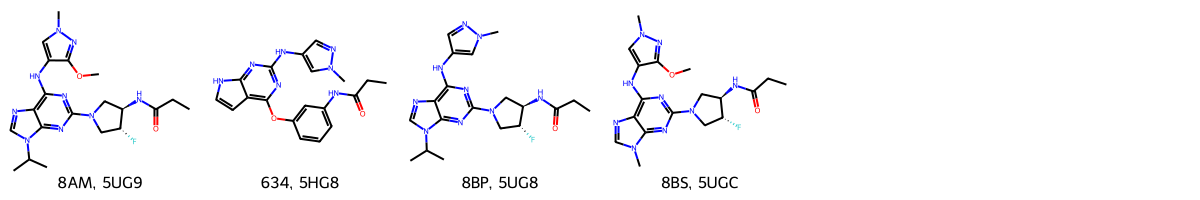

In [ ]:
PandasTools.AddMoleculeColumnToFrame(ligands, "smiles")
Draw.MolsToGridImage(
    mols=list(ligands.ROMol),
    legends=list(ligands["@chemicalID"] + ", " + ligands["@structureId"]),
    molsPerRow=top_num,
)

### Create protein-ligand ID pairs

In [ ]:
# NBVAL_CHECK_OUTPUT
pairs = collections.OrderedDict(zip(ligands["@structureId"], ligands["@chemicalID"]))
pairs

OrderedDict([('5UG9', '8AM'),
             ('5HG8', '634'),
             ('5UG8', '8BP'),
             ('5UGC', '8BS')])

### Align PDB structures and extract ligands

Since we want to build ligand-based ensemble pharmacophores in the next talktorial, it is necessary to align all structures to each other in 3D.

We will use the Python package `opencadd` ([repository](https://github.com/volkamerlab/opencadd)), which includes a 3D superposition subpackage  to guide the structural alignment of the proteins. The approach is based on superposition guided by sequence alignment of provided matched residues. There are other methods in the package, but this simple one will be enough for the task at hand.

#### Get the PDB structure files

We now fetch the PDB structure files, i.e. 3D coordinates of the protein, ligand (and if available other atomic or molecular entities such as cofactors, water molecules, and ions) from the PDB using `opencadd.structure.superposition`.

Available file formats are *pdb* and *cif*, which store the 3D coordinations of atoms of the protein (and ligand, cofactors, water molecules, and ions) as well as information on bonds between atoms. Here, we work with *pdb* files.

In [ ]:
# Download PDB structures
structures = [Structure.from_pdbid(pdb_id) for pdb_id in pairs]
structures

[<Universe with 2664 atoms>,
 <Universe with 2716 atoms>,
 <Universe with 2632 atoms>,
 <Universe with 2542 atoms>]

#### Extract protein and ligand

Extract protein and ligand from the structure in order to remove solvent and other artifacts of crystallography.

In [ ]:
complexes = [
    Structure.from_atomgroup(structure.select_atoms(f"protein or resname {ligand}"))
    for structure, ligand in zip(structures, pairs.values())
]
complexes

[<Universe with 2330 atoms>,
 <Universe with 2491 atoms>,
 <Universe with 2319 atoms>,
 <Universe with 2320 atoms>]

In [ ]:
# Write complex to file
for complex_, pdb_id in zip(complexes, pairs.keys()):
    complex_.write(DATA / f"{pdb_id}.pdb")

#Ideally we are done here.
We learned how to search PDB with the help of Notebook, also we remained able to pick our desired structures with some sort of filteration. Finally you are required to **Download** the Top_ligand file. We will use them in Part-8, to generate some pharmacophore models on them.

Good Luck⛹

If you want to run the below codes, can but not necessary

#### Extra Work - Align proteins

Align complexes (based on protein atoms).

In [ ]:
# Import necessary libraries
import nglview as nv
from io import StringIO
from Bio.PDB import PDBParser, PDBIO, Superimposer

# Parse the PDB files
parser = PDBParser()
struct1 = parser.get_structure("struct1", "/content/5HG8.pdb")
struct2 = parser.get_structure("struct2", "/content/5UG8.pdb")
struct3 = parser.get_structure("struct3", "/content/5UG9.pdb")
struct4 = parser.get_structure("struct4", "/content/5UGC.pdb")

# Create a Superimposer object
sup = Superimposer()

# Define the fixed and moving atoms
fixed_atoms = list(struct1.get_atoms())
moving_atoms = [list(struct2.get_atoms()), list(struct3.get_atoms()), list(struct4.get_atoms())]

# Ensure the lists have the same size
min_size = min(len(fixed_atoms), min(len(atoms) for atoms in moving_atoms))
fixed_atoms = fixed_atoms[:min_size]
moving_atoms = [atoms[:min_size] for atoms in moving_atoms]

# Perform the alignment
for atoms in moving_atoms:
    sup.set_atoms(fixed_atoms, atoms)
    sup.apply(atoms)

# Function to convert a Biopython structure to a PDB string
def structure_to_pdb_string(structure):
    pdb_io = PDBIO()
    pdb_io.set_structure(structure)
    string_io = StringIO()
    pdb_io.save(string_io)
    pdb_string = string_io.getvalue()
    return pdb_string

# Convert aligned structures to PDB strings
fixed_pdb_string = structure_to_pdb_string(struct1)
moving_pdb_strings = [structure_to_pdb_string(struct) for struct in [struct2, struct3, struct4]]

# Create file-like objects from PDB strings
fixed_file_obj = StringIO(fixed_pdb_string)
moving_file_objs = [StringIO(pdb_str) for pdb_str in moving_pdb_strings]

# Visualize the structures with nglview
view = nv.NGLWidget()
view.add_component(fixed_file_obj, ext="pdb")
for file_obj in moving_file_objs:
    view.add_component(file_obj, ext="pdb")

In [ ]:
view

`nglview` can be used to visualize molecular data within Jupyter notebooks. With the next cell we will visualize out aligned protein-ligand complexes.

Support for third party widgets will remain active for the duration of the session. To disable support:

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
view.render_image(trim=True, factor=2, transparent=True);

In [ ]:
image_data = view._display_image()


In [ ]:
view._display_image()

#### Extract ligands

In [ ]:
ligands = [
    Structure.from_atomgroup(complex_.select_atoms(f"resname {ligand}"))
    for complex_, ligand in zip(complexes, pairs.values())
]
ligands

[<Universe with 32 atoms>,
 <Universe with 28 atoms>,
 <Universe with 30 atoms>,
 <Universe with 30 atoms>]

In [ ]:
for ligand, pdb_id in zip(ligands, pairs.keys()):
    ligand.write(DATA / f"{pdb_id}_lig.pdb")

We check the existence of all ligand *pdb* files.

In [ ]:
ligands = [complex_.select_atoms(f"resname {ligand}").universe for complex_, ligand in zip(complexes, pairs.values())]

# Points to Mention
We learned how to search PDB with the help of Notebook, also we remained able to pick our desired structures with some sort of filteration. We also remained able to extract ligands from the selected structures. Finally you are required to **Download** the ligand files manually from this notebook. We will use them in Part-8, to generate some pharmacophore models on them.

Good Luck⛹